# Modeling with Population

Import necessary modules and metrics.

In [33]:
import pandas as pd
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 200)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import f1_score, accuracy_score, recall_score, confusion_matrix
from sklearn.utils import resample
from xgboost import XGBClassifier

import pickle


Import the California Wildfire Dataset

In [2]:
df = pd.read_csv('../data/california_wildfires.csv')

In [3]:
df

,Unnamed: 0,date,county,year,acres_burned,fire_started,Unnamed: 0.1,Alfalfa & Hay_acres,Alfalfa & Hay_percentage,Almonds_acres,Almonds_percentage,Barren_acres,Barren_percentage,Corn_acres,Corn_percentage,Cotton_acres,Cotton_percentage,Deciduous Forest_acres,Deciduous Forest_percentage,Evergreen Forest_acres,Evergreen Forest_percentage,Fallow_acres,Fallow_percentage,Fruit Trees_acres,Fruit Trees_percentage,Grain Crops_acres,Grain Crops_percentage,Grapes_acres,Grapes_percentage,Grassland_acres,Grassland_percentage,High Intensity Developed_acres,High Intensity Developed_percentage,Low Intensity Developed_acres,Low Intensity Developed_percentage,Mixed Forest_acres,Mixed Forest_percentage,Other Ocean/Mexico_acres,Other Ocean/Mexico_percentage,Other Tree Crops_acres,Other Tree Crops_percentage,Other_acres,Other_percentage,Rice_acres,Rice_percentage,Shrubland_acres,Shrubland_percentage,Tomatoes_acres,Tomatoes_percentage,Vegs & Fruits_acres,Vegs & Fruits_percentage,Walnuts_acres,Walnuts_percentage,Water_acres,Water_percentage,Wetlands_acres,Wetlands_percentage,Winter Wheat_acres,Winter Wheat_percentage,max_elevation,min_elevation,Avg Air Temp (F)_Weekly,Avg Rel Hum (%)_Weekly,Avg Wind Speed (mph)_Weekly,Dew Point (F)_Weekly,Max Air Temp (F)_Weekly,Max Rel Hum (%)_Weekly,Min Air Temp (F)_Weekly,Min Rel Hum (%)_Weekly,Precip (in)_Weekly,Avg Air Temp (F)_month,Avg Rel Hum (%)_month,Avg Wind Speed (mph)_month,Dew Point (F)_month,Max Air Temp (F)_month,Max Rel Hum (%)_month,Min Air Temp (F)_month,Min Rel Hum (%)_month,Precip (in)_month,Population,county_acres,pop_density
0,0,2013-01-06,Alameda,2013,0.0,0.0,2,1102.856805,0.300074,4.225505,0.001150,194.595625,0.052947,4.670295,0.001271,0.000000,0.000000,5.337480,0.001452,7838.756565,2.132827,1536.749450,0.418130,1.779160,0.000484,991.214515,0.269697,3722.447510,1.012831,153671.386680,41.812059,28431.421590,7.735834,39470.886995,10.739534,74885.956375,20.375531,0.0,0.0,8.673405,0.002360,0.0,0.0,0.889580,0.000242,30958.051185,8.423298,4.670295,0.001271,164.127510,0.044657,4.670295,0.001271,19403.518960,5.279454,4497.494085,1.223712,624.485160,0.169915,1242,-42,44.214286,82.785714,2.392857,39.321429,54.157143,96.500000,35.771429,60.785714,0.095714,45.506897,78.189655,2.915517,38.932759,55.896552,95.448276,35.725862,55.810345,0.130172,1567167,528000,2.968119
1,1,2013-01-06,Alpine,2013,0.0,0.0,2,189.035750,0.040080,0.000000,0.000000,15482.472715,3.282650,0.000000,0.000000,0.000000,0.000000,194.595625,0.041259,195088.007530,41.363269,0.444790,0.000094,0.222395,0.000047,0.000000,0.000000,0.000000,0.000000,5644.829890,1.196837,121.427670,0.025746,3192.480225,0.676881,0.667185,0.000141,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,247783.390805,52.535935,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2650.503610,0.561969,1297.452430,0.275091,0.000000,0.000000,3556,1442,29.657143,76.514286,3.228571,21.328571,34.428571,91.857143,22.857143,55.428571,0.000000,30.789655,68.162069,4.968966,19.600000,39.344828,86.000000,22.758621,46.344828,0.000000,1164,465280,0.002502
2,2,2013-01-06,Amador,2013,0.0,0.0,2,1326.808570,0.414290,16.679625,0.005208,1873.010690,0.584840,242.632945,0.075761,0.000000,0.000000,17190.911105,5.367789,114386.866695,35.716810,168.130620,0.052498,12.009330,0.003750,120.093300,0.037499,2587.343430,0.807887,112912.610240,35.256480,440.119705,0.137425,8263.975805,2.580391,1727.119570,0.539286,0.0,0.0,1.334370,0.000417,0.0,0.0,1.111975,0.000347,52457.865415,16.379744,0.000000,0.000000,1.779160,0.000556,122.094855,0.038124,5822.745890,1.818128,105.860020,0.033054,479.483620,0.149717,3121,43,34.114286,83.571429,3.157143,29.585714,40.071429,96.000000,27.757143,66.571429,0.141429,34.289655,76.724138,3.606897,27.410345,41.200000,93.172414,27.768966,58.310345,0.155517,37304,384640,0.096984
3,3,2013-01-06,Butte,2013,0.0,0.0,2,3777.156680,0.374865,46196.556585,4.584787,1869.452370,0.185534,2023.349710,0.200808,9.118195,0.000905,33181.556395,3.293111,408193.790775,40.511281,56434.510410

## Creating Dummy Variables for Categorical Features

There are two features that are categorical. The counties and the month of the year column that we engineered.

In [4]:
# Create dummy variables for the county column
counties = pd.get_dummies(df.county, drop_first = True)
# Drop county column along with unnecessary columns (Unnamed columns, year, and acres burned)
df2 = df.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1', 'county', 'year', 'acres_burned'], axis = 1)

In [5]:
# Feature engineer month column from the date column
df2['month'] = pd.DatetimeIndex(df2['date']).month
# Drop the date column
df2.drop(columns = ['date'], axis = 1, inplace = True)

In [6]:
# Create dummy variables for the months
month = pd.get_dummies(df2.month, drop_first = True)
# Drop the month column
df2.drop(columns = 'month', axis =1, inplace = True)

In [7]:
# Combine the original dataframe with the dummy variables
df2 = pd.concat([df2, counties, month], axis = 1)

## Train-Test Split

We want to split our data into a training dataset and a test dataset. We want to do this before we work on the class imbalance so that we have a holdout set of data to test the model on.

In [8]:
# Split dataset into target variable and features
y = df2.fire_started
X = df2.drop(columns = ['fire_started'], axis = 1)

In [9]:
# Use train_test_split to create a training dataset and test dataset
X_train, X_test, y_train, y_test = train_test_split(X,  y, test_size = 0.25, random_state = 0)

## Upsampling Minority Class

There is a high class imbalance in the target variable. As seen in the EDA, the grand majority of the target variable are instances of no wildfire. In this case, we use upsampling the instances of wildfire to resolve the class imbalance issue. The first step to combine the `X_train` and `y_train` dataframes back into one dataframe. 

In [10]:
# Concatenate the X_train and y_train back into one training dataframe
training = pd.concat([X_train, y_train], axis=1)

The second step is to split the dataframe into the majority class and the minority class. In this case, the majority class are observations of weeks with no wildfire incidents. The minority class are observations of weeks with one or more wildfire incidents.

In [11]:
# Split the target variable by class into two dataframes
no_fire = training[training.fire_started == 0] # 0 = No Wildfire
fire = training[training.fire_started == 1] # 1 = Wildfire

The third step is to upsample the minority class with replacement. The minority class should be equal to the same number of observations and then recombine the two class dataframes back into one.

In [12]:
# Resample the minority class (wildfire)
fire_upsampled = resample(fire,
                          replace=True, # sample with replacement
                          n_samples=no_fire.shape[0], # match number in majority class
                          random_state=42) # reproducible result

In [13]:
# Create a new dataframe combining the target classes
resampled_df = pd.concat([no_fire, fire_upsampled])

In [14]:
# Double-check the different target classes
resampled_df.fire_started.value_counts()

1.0    12812
0.0    12812
Name: fire_started, dtype: int64

There is no longer any class imbalance between incidents of wildfire and incidents with no wildfires. We split the dataframe back into training target variable and the training features.

In [15]:
y_train = resampled_df.fire_started
X_train = resampled_df.drop(columns = ['fire_started'], axis = 1)

## Logistic Regression

The first type of model we tried was logistic regression

### Base Model

For our base model, we run the resampled training data through a logistic regression model with default settings

In [16]:
The results of our metrics show that the recall score is higher than the accuracy score, and we have a low f1 score. We use a confusion matrix to find the false positive and false negative values.# Instantiate a logistic regression model
logreg = LogisticRegression(random_state = 0) # random state for consistant results
# Train model on resampled training data
logreg.fit(X_train, y_train)

/Users/malcolmkatzenbach/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(random_state=0)

In [17]:
# Use the model to predict the target variable on the training dataset
y_hat_train = logreg.predict(X_train)
# Use the model to predict the target variable on the test dataset
y_hat_test = logreg.predict(X_test)

In [18]:
# Print the f1 score metric on both the training and test predictions to check for overfitting
print('F1 Score: Training', f1_score(y_train, y_hat_train), 'Test', f1_score(y_test, y_hat_test))
# Print the accuracy score metric on both the training and test predictions to check for overfitting
print('Accuracy Score: Training', accuracy_score(y_train, y_hat_train), 'Test', accuracy_score(y_test, y_hat_test))
# Print the recall score metric on both the training and test predictions to check for overfitting
print('Recall Score: Training', recall_score(y_train, y_hat_train), 'Test', recall_score(y_test, y_hat_test))

F1 Score: Training 0.6259625586091242 Test 0.1420159334949775
Accuracy Score: Training 0.5734857945675929 Test 0.45428508482044505
Recall Score: Training 0.7137839525444896 Test 0.7068965517241379


The results of our metrics show that the recall score is higher than the accuracy score, and we have a low f1 score. We use a confusion matrix to find the false positive and false negative values.

In [19]:
confusion_matrix(y_test, y_hat_test)

array([[1857, 2392],
       [  85,  205]])

From the confusion matrix, the majority of predictions are false positives. We want to try to decrease the number of false positives in our next model.

### Model - Scaled Data

In our first iteration we want to check how normalizing the features will change our score. To normalize our data, we will use a Standard Scaler.

In [20]:
# Insantiate the StandardScaler()
ss = StandardScaler()
# Fit the feature training data
ss.fit(X_train)

# Transform both the training and test features
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

In [212]:
# Pickle Standar Scaler
pickle_out = open("../Models/ss.pickle","wb")
pickle.dump(ss, pickle_out)
pickle_out.close()

In [21]:
# Instantiate a new logistic regression model
logreg1 = LogisticRegression(solver = 'liblinear')
# Fit the data to the new scaled data
logreg1.fit(X_train_scaled, y_train)

LogisticRegression(solver='liblinear')

In [22]:
# Use model to predict target variable on the training dataset
y_hat_train1 = logreg1.predict(X_train_scaled)
# Use model to predict target variable on the test dataset
y_hat_test1 = logreg1.predict(X_test_scaled)

In [23]:
# Print the f1 score metric on both the training and test predictions to check for overfitting
print('F1 Score: Training', f1_score(y_train, y_hat_train1), 'Test', f1_score(y_test, y_hat_test1))
# Print the accuracy score metric on both the training and test predictions to check for overfitting
print('Accuracy Score: Training', accuracy_score(y_train, y_hat_train1), 'Test', accuracy_score(y_test, y_hat_test1))
# Print the recall score metric on both the training and test predictions to check for overfitting
print('Recall Score: Training', recall_score(y_train, y_hat_train1), 'Test', recall_score(y_test, y_hat_test1))

F1 Score: Training 0.8157728940443985 Test 0.28536436007348437
Accuracy Score: Training 0.8060021854511396 Test 0.7428949107732981
Recall Score: Training 0.8590384014985951 Test 0.803448275862069


The results from our metrics show an increase in score across the board. However, the recall and accuracy score are still much better than the f1 score. The f1 score is highly overfit, while the recall and accuracy scores are slightly overfit. We check the confusion matrix next to check the value counts for false positive and false negatives.

In [24]:
confusion_matrix(y_test, y_hat_test1)

array([[3139, 1110],
       [  57,  233]])

The confusion matrix shows as in the previous model, the most error occurs from the model predicting false positives, however we have decrease the number of false positives by more than half.

### Validation

In [69]:
scores = cross_val_score(logreg1, X_train_scaled, y_train, cv=10)
print(scores.mean())

0.8017092607432437


### Pickle Model

In [209]:
# pickle logistic model
with open("../models/best_logistic.pickle", "wb") as best_logistic:
    pickle.dump(logreg1, best_logistic)

### Error Analysis

In [84]:
predicted = pd.concat([X_test, y_test], axis = 1)
predicted

,Alfalfa & Hay_acres,Alfalfa & Hay_percentage,Almonds_acres,Almonds_percentage,Barren_acres,Barren_percentage,Corn_acres,Corn_percentage,Cotton_acres,Cotton_percentage,Deciduous Forest_acres,Deciduous Forest_percentage,Evergreen Forest_acres,Evergreen Forest_percentage,Fallow_acres,Fallow_percentage,Fruit Trees_acres,Fruit Trees_percentage,Grain Crops_acres,Grain Crops_percentage,Grapes_acres,Grapes_percentage,Grassland_acres,Grassland_percentage,High Intensity Developed_acres,High Intensity Developed_percentage,Low Intensity Developed_acres,Low Intensity Developed_percentage,Mixed Forest_acres,Mixed Forest_percentage,Other Ocean/Mexico_acres,Other Ocean/Mexico_percentage,Other Tree Crops_acres,Other Tree Crops_percentage,Other_acres,Other_percentage,Rice_acres,Rice_percentage,Shrubland_acres,Shrubland_percentage,Tomatoes_acres,Tomatoes_percentage,Vegs & Fruits_acres,Vegs & Fruits_percentage,Walnuts_acres,Walnuts_percentage,Water_acres,Water_percentage,Wetlands_acres,Wetlands_percentage,Winter Wheat_acres,Winter Wheat_percentage,max_elevation,min_elevation,Avg Air Temp (F)_Weekly,Avg Rel Hum (%)_Weekly,Avg Wind Speed (mph)_Weekly,Dew Point (F)_Weekly,Max Air Temp (F)_Weekly,Max Rel Hum (%)_Weekly,Min Air Temp (F)_Weekly,Min Rel Hum (%)_Weekly,Precip (in)_Weekly,Avg Air Temp (F)_month,Avg Rel Hum (%)_month,Avg Wind Speed (mph)_month,Dew Point (F)_month,Max Air Temp (F)_month,Max Rel Hum (%)_month,Min Air Temp (F)_month,Min Rel Hum (%)_month,Precip (in)_month,Population,county_acres,pop_density,Alpine,Amador,Butte,Calaveras,Colusa,Contra Costa,Del Norte,El Dorado,Fresno,Glenn,Humboldt,Imperial,Inyo,Kern,Kings,Lake,Lassen,Los Angeles,Madera,Marin,Mariposa,Mendocino,Merced,Modoc,Mono,Monterey,Napa,Nevada,Orange,Placer,Plumas,Riverside,Sacramento,San Benito,San Bernardino,San Diego,San Francisco,San Joaquin,San Luis Obispo,San Mateo,Santa Barbara,Santa Clara,Santa Cruz,Shasta,Sierra,Siskiyou,Solano,Sonoma,Stanislaus,Sutter,Tehama,Trinity,Tulare,Tuolumne,Ventura,Yolo,Yuba,2,3,4,5,6,7,8,9,10,11,12,fire_started
12930,17.791600,0.001264,3.780715,0.000269,120475.152215,8.559617,0.000000,0.000000,0.000000,0.000000,17857.428920,1.268749,673694.279255,47.865180,9.562985,0.000679,1.779160,0.000126,1.556765,0.000111,0.889580,0.000063,107346.063390,7.626811,556.432290,0.039534,11897.687710,0.845317,265.094840,0.018835,0.0,0.0,1.556765,0.000111,0.0,0.0,0.000000,0.000000,4.451974e+05,31.630749,0.000000,0.000000,0.000000,0.000000,0.222395,0.000016,29309.214655,2.082385,816.189650,0.057989,30.912905,0.002196,3959,374,60.528571,60.714286,11.685714,44.942857,73.714286,88.285714,48.000000,33.000000,0.004286,59.082759,70.362069,7.817241,47.824138,70.793103,93.379310,48.689655,41.827586,0.098276,54725,1467520,0.037291,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0
17287,5199.595100,0.516035,36487.680465,3.621228,2509.060390,0.249012,348.270570,0.034564,221.505420,0.021983,36955.154755,3.667622,389571.545450,38.663112,82134.254215,8.151432,19776.252980,1.962698,919.380930,0.091244,42.477445,0.004216,148690.405865,14.756811,5127.316725,0.508862,28198.796420,2.798596,583.786875,0.057938,0.0,0.0,2598.240785,0.257863,0.0,0.0,79618.521975,7.901757,8.180177e+04,8.118435,777.715315,0.077185,516.401190,0.051250,51968.374020,5.157612,21834.741100,2.166994,11160.893075,1.107665,563.104140,0.055885,2192,-1,64.800000,61.142857,2.242857,51.114286,81.900000,90.714286,50.757143,31.285714,0.000000,68.113793,61.172414,2.162069,54.089655,86.786207,92.413793,52.775862,32.620690,0.000000,227621,1065600,0.213608,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0
11545,3504.945200,0.347849,43919.676575,4.358818,2064.937575,0.204935,270.209925,0.026817,81.396570,0.008078,36126.733380,3.585405,391415.422395,38.846108,63940.786450,6.345817,8684.302355,0.861875,568.886410,0.056459,393.416755,0.03904

In [86]:
predicted.loc[predicted.fire_started != y_hat_test1].describe()

,Alfalfa & Hay_acres,Alfalfa & Hay_percentage,Almonds_acres,Almonds_percentage,Barren_acres,Barren_percentage,Corn_acres,Corn_percentage,Cotton_acres,Cotton_percentage,Deciduous Forest_acres,Deciduous Forest_percentage,Evergreen Forest_acres,Evergreen Forest_percentage,Fallow_acres,Fallow_percentage,Fruit Trees_acres,Fruit Trees_percentage,Grain Crops_acres,Grain Crops_percentage,Grapes_acres,Grapes_percentage,Grassland_acres,Grassland_percentage,High Intensity Developed_acres,High Intensity Developed_percentage,Low Intensity Developed_acres,Low Intensity Developed_percentage,Mixed Forest_acres,Mixed Forest_percentage,Other Ocean/Mexico_acres,Other Ocean/Mexico_percentage,Other Tree Crops_acres,Other Tree Crops_percentage,Other_acres,Other_percentage,Rice_acres,Rice_percentage,Shrubland_acres,Shrubland_percentage,Tomatoes_acres,Tomatoes_percentage,Vegs & Fruits_acres,Vegs & Fruits_percentage,Walnuts_acres,Walnuts_percentage,Water_acres,Water_percentage,Wetlands_acres,Wetlands_percentage,Winter Wheat_acres,Winter Wheat_percentage,max_elevation,min_elevation,Avg Air Temp (F)_Weekly,Avg Rel Hum (%)_Weekly,Avg Wind Speed (mph)_Weekly,Dew Point (F)_Weekly,Max Air Temp (F)_Weekly,Max Rel Hum (%)_Weekly,Min Air Temp (F)_Weekly,Min Rel Hum (%)_Weekly,Precip (in)_Weekly,Avg Air Temp (F)_month,Avg Rel Hum (%)_month,Avg Wind Speed (mph)_month,Dew Point (F)_month,Max Air Temp (F)_month,Max Rel Hum (%)_month,Min Air Temp (F)_month,Min Rel Hum (%)_month,Precip (in)_month,Population,county_acres,pop_density,Alpine,Amador,Butte,Calaveras,Colusa,Contra Costa,Del Norte,El Dorado,Fresno,Glenn,Humboldt,Imperial,Inyo,Kern,Kings,Lake,Lassen,Los Angeles,Madera,Marin,Mariposa,Mendocino,Merced,Modoc,Mono,Monterey,Napa,Nevada,Orange,Placer,Plumas,Riverside,Sacramento,San Benito,San Bernardino,San Diego,San Francisco,San Joaquin,San Luis Obispo,San Mateo,Santa Barbara,Santa Clara,Santa Cruz,Shasta,Sierra,Siskiyou,Solano,Sonoma,Stanislaus,Sutter,Tehama,Trinity,Tulare,Tuolumne,Ventura,Yolo,Yuba,2,3,4,5,6,7,8,9,10,11,12,fire_started
count,1167.000000,1167.000000,1167.000000,1167.000000,1.167000e+03,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1.167000e+03,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1.167000e+03,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1.167000e+03,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1.167000e+03,1.167000e+03,1167.000000,1167.0,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.0,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.0,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000
mean,23313.990675,1.561762,22064.063504,1.371046,1.075054e+05,2.498277,2427.321938,0.315772,4184.554972,0.215082,9766.566374,0.924501,4.356794e+05,24.284078,25891.105460,1.596966,7149.825641,0.350702,11451.757340,0.843314,18699.079653,1

Looking at the statistics on the observations that were incorrectly predicted shows that for ground cover, the most common errors were in counties with large perecentages of Grassland (16.6%) and Shrubland (32.79%). There does not seem to be any specific range of elevations for errors. Most of the errors occured when the precipitation was low and the temperature cooler. The errors also seem to occur mostly where the the population was less than 1 person per acre. Some of the top counties with erros are Monterey, Riverside, San Bernadino, San Diego and Ventura with more than 3%. Most of the error occurs in the summer months (June, July, August, and September). 

## K Nearest Neighbors (KNN) Models

The second type of model we used was K Nearest Neighbor

### Base Model

For our base knn model, we chose k as 3. Due to how knn models function, the number of nearest neighbors should always be odd.

In [213]:
from sklearn.neighbors import KNeighborsClassifier

In [214]:
# Instantiate a knn model using 3 nearest neighbors
knn = KNeighborsClassifier(n_neighbors = 3)

In [215]:
# Fit knn model using the scaled data from the previous scaled logistic model
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=3)

In [216]:
# Predict target variable for both the train and test datasets.
knn_train = knn.predict(X_train_scaled)
knn_test = knn.predict(X_test_scaled)

In [217]:
# Print the f1 score metric on both the training and test predictions to check for overfitting
print('F1 Score: Training', f1_score(y_train, knn_train), 'Test', f1_score(y_test, knn_test))
# Print the sccuracy score metric on both the training and test predictions to check for overfitting
print('Accuracy Score: Training', accuracy_score(y_train, knn_train), 'Test', accuracy_score(y_test, knn_test))
# Print the recall score metric on both the training and test predictions to check for overfitting
print('Recall Score: Training', recall_score(y_train, knn_train), 'Test', recall_score(y_test, knn_test))

F1 Score: Training 0.975706343766659 Test 0.2788339670468948
Accuracy Score: Training 0.9751014673743366 Test 0.874641991628112
Recall Score: Training 1.0 Test 0.3793103448275862


The results show that while the test accuracy is high, the recall score and the f1 score are highly overfit. We check the confusion matrix to check the values of the false positive and false negatives.

### Tuning Number of Nearest Neighbors

To tune the number (k) nearest neighbors, want to find the value of k that will return the max value for a given metric. Due to the business problem of wildfires, we want to reduce the number of false positives and thus maximise recall. 

In [218]:
# Create a function to find the max recall score and return the score along with the k value
def max_value(l):
    max_val = max(l)
    max_idx = l.index(max_val)
    return max_idx, max_val

In [219]:
# Create an empty list for recall scores
k_scores = []
# Choose a range of k values to test
k_range = list(range(1, 21))
# Iterate through the different k values
for k in k_range:
    # Instantiate new knn model with k nearest neighbors
    knn = KNeighborsClassifier(n_neighbors = k)
    # Fit knn model on scaled training data
    knn.fit(X_train_scaled, y_train)
    # Use model to predict target variable on testing set
    y_pred = knn.predict(X_test_scaled)
    # Find the recall score
    recall = recall_score(y_test, y_pred)
    # Append recall score to list of recall scorees
    k_scores.append(recall)

# Find max recall score
idx, val = max_value(k_scores)
# Print max recall score and it corresponding k value
print(idx + 1, val)

19 0.7413793103448276


The best k value is 19 with a recall score of 74%. We rerun the model using k=19 and check the f1 and accuracy metrics of the model

In [220]:
knn = KNeighborsClassifier(n_neighbors = 19)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)
knn_train1 = knn.predict(X_train_scaled)
print('F1 Score: Training', f1_score(y_train, knn_train1), 'Test', f1_score(y_test, y_pred))
print('Accuracy Score: Training', accuracy_score(y_train, knn_train1), 'Test', accuracy_score(y_test, y_pred))
print('Recall Score: Training', recall_score(y_train, knn_train1), 'Test', recall_score(y_test, y_pred))

F1 Score: Training 0.883275080458179 Test 0.24826789838337182
Accuracy Score: Training 0.8683655947549173 Test 0.7131526768010575
Recall Score: Training 0.9960974086793631 Test 0.7413793103448276


This model has a highly increased test scores for recall, however the accuracy is much worse and the f1 score slight worse. The model is still highly overfit.

In [221]:
confusion_matrix(y_test, y_pred)

array([[3022, 1227],
       [  75,  215]])

The majority of error from this model is still predicting false positives.

### Validation

In [222]:
scores_knn = cross_val_score(knn, X_train_scaled, y_train, cv=10)
print(scores_knn.mean())

0.8476827201973194


### Pickle Model

In [223]:
# Pickle KNN model
with open("../models/best_knn.pickle", "wb") as best_knn:
    pickle.dump(knn, best_knn)

## Decision Tree

### Base Model

For our base model we will instantiate a Decision Tree Classifier with default settings.

In [224]:
from sklearn.tree import DecisionTreeClassifier

In [225]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [226]:
dt_train = dt.predict(X_train)
dt_test = dt.predict(X_test)

print('F1 Score: Training', f1_score(y_train, dt_train), 'Test', f1_score(y_test, dt_test))
print('Accuracy Score: Training', accuracy_score(y_train, dt_train), 'Test', accuracy_score(y_test, dt_test))
print('Recall Score: Training', recall_score(y_train, dt_train), 'Test', recall_score(y_test, dt_test))

F1 Score: Training 1.0 Test 0.23693379790940766
Accuracy Score: Training 1.0 Test 0.9035029742233972
Recall Score: Training 1.0 Test 0.23448275862068965


The base model has a high accuracy score, but a low f1 and recall score. The model is also highly overfit.

In [227]:
confusion_matrix(y_test, dt_test)

array([[4033,  216],
       [ 222,   68]])

The majority of the error is from predicting false negatives, while the false positives are also high.

### GridSearchCV

In [228]:
from sklearn.model_selection import GridSearchCV

For the first tuning, we want to check a wide range for the parameters of max depth, max_features and the min_sample_split.

In [229]:
parameters = {'max_depth' : range(1, 15, 1), 'max_features' : range(55, 75, 1), 'min_samples_split' : range(10, 20, 1)}

In the grid search, we use the f1 scoring metric so that ideally both accuracy and recall scores will increase.

In [230]:
dtg = DecisionTreeClassifier(random_state = 0)
grid_model = GridSearchCV(dtg, parameters, cv = 10, scoring = 'f1', verbose = 1, n_jobs = -1)

grid_model.fit(X_train, y_train)

Fitting 10 folds for each of 2800 candidates, totalling 28000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:   54.0s
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 6018 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 7168 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 8418 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 9768 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 11218 tasks      

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': range(1, 15),
                         'max_features': range(55, 75),
                         'min_samples_split': range(10, 20)},
             scoring='f1', verbose=1)

In [231]:
print(grid_model.best_score_)
print(grid_model.best_params_)
print(grid_model.best_estimator_)

0.9242561036170699
{'max_depth': 14, 'max_features': 62, 'min_samples_split': 17}
DecisionTreeClassifier(max_depth=14, max_features=62, min_samples_split=17,
                       random_state=0)


In [232]:
dt_train2 = dt.predict(X_train)
dt_test2 = dt.predict(X_test)

print('F1 Score: Training', f1_score(y_train, dt_train2), 'Test', f1_score(y_test, dt_test2))
print('Accuracy Score: Training', accuracy_score(y_train, dt_train2), 'Test', accuracy_score(y_test, dt_test2))
print('Recall Score: Training', recall_score(y_train, dt_train2), 'Test', recall_score(y_test, dt_test2))

F1 Score: Training 1.0 Test 0.23693379790940766
Accuracy Score: Training 1.0 Test 0.9035029742233972
Recall Score: Training 1.0 Test 0.23448275862068965


The model is still highly overfit. The test recall and f1 score are still much worse than the test score.

In [233]:
confusion_matrix(y_test, dt_test2)

array([[4033,  216],
       [ 222,   68]])

The model the majority of the error is still in predicting false negatives, hence the low recall score.

### GridSearchCV 2

In the previous model, the results showed that it was highly overfit and could not generalize well. By reducing the `max_depth`, it should reduce the overfitting. In the previous model the `min_samples_split` was at a high end of the range, so for model we increase the range. The `max_features` will test a lower range of features.

In [234]:
parameters2 = {'max_depth' : range(10, 13, 1), 'max_features' : range(35, 65, 1), 'min_samples_split' : range(14, 30, 1)}

In [235]:
dtg2 = DecisionTreeClassifier(random_state = 0)
dtg2_model = GridSearchCV(dtg2, parameters2, cv = 10, scoring = 'f1', verbose = 1, n_jobs = -1)

dtg2_model.fit(X_train, y_train)

Fitting 10 folds for each of 1440 candidates, totalling 14400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 6018 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 7168 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 8418 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 9768 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 11218 tasks      

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': range(10, 13),
                         'max_features': range(35, 65),
                         'min_samples_split': range(14, 30)},
             scoring='f1', verbose=1)

In [236]:
print(dtg2_model.best_score_)
print(dtg2_model.best_params_)
print(dtg2_model.best_estimator_)

0.9151798193645881
{'max_depth': 12, 'max_features': 52, 'min_samples_split': 15}
DecisionTreeClassifier(max_depth=12, max_features=52, min_samples_split=15,
                       random_state=0)


In [237]:
dt_train3 = dtg2_model.predict(X_train)
dt_test3 = dtg2_model.predict(X_test)

print('F1 Score: Training', f1_score(y_train, dt_train3), 'Test', f1_score(y_test, dt_test3))
print('Accuracy Score: Training', accuracy_score(y_train, dt_train3), 'Test', accuracy_score(y_test, dt_test3))
print('Recall Score: Training', recall_score(y_train, dt_train3), 'Test', recall_score(y_test, dt_test3))

F1 Score: Training 0.9134525605113841 Test 0.26426426426426425
Accuracy Score: Training 0.9059475491726506 Test 0.7840934126459572
Recall Score: Training 0.9926631283172026 Test 0.6068965517241379


The model has reduced overfitting. The accuracy test score has decreased, while the Recall test score has increased significantly. The F1 test score is still low meaning most of our error is predicting false positives.

### GridSearch 3

In the next model we will reduce the `max_depth` again to reduce any overfitting.

In [238]:
parameters3 = {'max_depth' : range(8, 9, 1), 'max_features' : range(35, 65, 1), 'min_samples_split' : range(14, 30, 1)}

In [239]:
dtg3 = DecisionTreeClassifier(random_state = 0)
dtg3_model = GridSearchCV(dtg3, parameters3, cv = 10, scoring = 'f1', verbose = 1, n_jobs = -1)

dtg3_model.fit(X_train, y_train)

Fitting 10 folds for each of 480 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed:  1.7min finished


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': range(8, 9),
                         'max_features': range(35, 65),
                         'min_samples_split': range(14, 30)},
             scoring='f1', verbose=1)

In [240]:
print(dtg3_model.best_score_)
print(dtg3_model.best_params_)
print(dtg3_model.best_estimator_)

0.8665665288129925
{'max_depth': 8, 'max_features': 42, 'min_samples_split': 20}
DecisionTreeClassifier(max_depth=8, max_features=42, min_samples_split=20,
                       random_state=0)


In [241]:
dt_train4 = dtg3_model.predict(X_train)
dt_test4 = dtg3_model.predict(X_test)

print('F1 Score: Training', f1_score(y_train, dt_train4), 'Test', f1_score(y_test, dt_test4))
print('Accuracy Score: Training', accuracy_score(y_train, dt_train4), 'Test', accuracy_score(y_test, dt_test4))
print('Recall Score: Training', recall_score(y_train, dt_train4), 'Test', recall_score(y_test, dt_test4))

F1 Score: Training 0.8702843468468469 Test 0.2608173076923077
Accuracy Score: Training 0.8561504839213238 Test 0.7290152015862524
Recall Score: Training 0.9651108335935061 Test 0.7482758620689656


The recall test score has increased again, but is now above the accuracy score. The recall score is greater than it was without the population and population density features. 

In [242]:
# Pickle Decision Tree Model
with open("../models/best_decision_tree.pickle", "wb") as best_decision_tree:
    pickle.dump(dtg3_model.best_estimator_, best_decision_tree)

## Random Forest Classifier

### Base Model

For the base model we instantiate a Random Forest Classifier with a set `random_state` for reproducibility and kept everything else at their default settings.

In [27]:
rfc = RandomForestClassifier(random_state = 0)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [28]:
rfc_train = rfc.predict(X_train)
rfc_test = rfc.predict(X_test)

In [29]:
print('F1 Score: Training', f1_score(y_train, rfc_train), f1_score(y_test, rfc_test))
print('Accuracy Score: Training', accuracy_score(y_train, rfc_train), accuracy_score(y_test, rfc_test))
print('Recall Score: Training', recall_score(y_train, rfc_train), recall_score(y_test, rfc_test))

F1 Score: Training 1.0 0.28384279475982527
Accuracy Score: Training 1.0 0.9277373870896674
Recall Score: Training 1.0 0.22413793103448276


As seen in previous models, the base model was able to have perfect training scores, however from the f1 score and recall, the model is highly overfit.

In [30]:
confusion_matrix(y_test, rfc_test)

array([[4146,  103],
       [ 225,   65]])

The majority of error from this model occurs in the predictions of false negatives. We want to maximize the recall score, while not boosting the number of false positives too high.

### Tuning Parameters - GridSearchCV

We use gridSearch to reduce the overfitting of the model and increase the test scores. The chosen parameters to be tuned are `n_estimators`, `criterion`, `min_samples_split`, and `max_features`.

In [31]:
param_grid1 = { 
    'n_estimators': [75, 100, 125],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': list(range(100, 102)),
    'max_features': list(range(30, 40))
}

In [34]:
rfc_grid = GridSearchCV(RandomForestClassifier(random_state = 0), param_grid1, cv=5, scoring='f1', verbose=1, n_jobs=-1)

In [35]:
rfc_grid.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 12.3min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': [30, 31, 32, 33, 34, 35, 36, 37, 38,
                                          39],
                         'min_samples_split': [100, 101],
                         'n_estimators': [75, 100, 125]},
             scoring='f1', verbose=1)

In [36]:
print(rfc_grid.best_score_)
print(rfc_grid.best_params_)
print(rfc_grid.best_estimator_)

0.9428839896424058
{'criterion': 'entropy', 'max_features': 38, 'min_samples_split': 100, 'n_estimators': 125}
RandomForestClassifier(criterion='entropy', max_features=38,
                       min_samples_split=100, n_estimators=125, random_state=0)


From the best paramters, the number of estimators is 125 and we can further tune this parameter by also checking 100 and 150. The max features is 38, which is at the high end of the range tested. The `min_samples_split` is at the low end of the range checked as expected.

In [37]:
rfc_grid_train = rfc_grid.best_estimator_.predict(X_train)
rfc_grid_test = rfc_grid.best_estimator_.predict(X_test)
print('F1 Score: Training', f1_score(y_train, rfc_grid_train), f1_score(y_test, rfc_grid_test))
print('Accuracy Score: Training', accuracy_score(y_train, rfc_grid_train), accuracy_score(y_test, rfc_grid_test))
print('Recall Score: Training', recall_score(y_train, rfc_grid_train), recall_score(y_test, rfc_grid_test))

F1 Score: Training 0.9734873191881211 0.3333333333333333
Accuracy Score: Training 0.973033093974399 0.8889623265036352
Recall Score: Training 0.990165469871995 0.43448275862068964


The recall test score has increased by more than 20%, while the accuracy test score has decreased by 4% and the F1 score has increased.

### Tuning Parameters - GridSearchCV 2

We increase the `min_samples_split` to reduce the overfitting and check a new set of `n_estimators`.

In [38]:
param_grid2 = { 
    'n_estimators': [100, 125, 150],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': list(range(200, 202)),
    'max_features': list(range(30, 40))
}

In [39]:
rfc_grid2 = GridSearchCV(RandomForestClassifier(random_state = 0), param_grid2, cv=5, scoring='f1', verbose=1, n_jobs=-1)

In [42]:
rfc_grid2.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 14.2min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': [30, 31, 32, 33, 34, 35, 36, 37, 38,
                                          39],
                         'min_samples_split': [200, 201],
                         'n_estimators': [100, 125, 150]},
             scoring='f1', verbose=1)

In [43]:
print(rfc_grid2.best_score_)
print(rfc_grid2.best_params_)
print(rfc_grid2.best_estimator_)

0.9049666579930428
{'criterion': 'gini', 'max_features': 37, 'min_samples_split': 200, 'n_estimators': 100}
RandomForestClassifier(max_features=37, min_samples_split=200, random_state=0)


In [44]:
rfc_grid2_train = rfc_grid2.best_estimator_.predict(X_train)
rfc_grid2_test = rfc_grid2.best_estimator_.predict(X_test)
print('F1 Score: Training', f1_score(y_train, rfc_grid2_train), f1_score(y_test, rfc_grid2_test))
print('Accuracy Score: Training', accuracy_score(y_train, rfc_grid2_train), accuracy_score(y_test, rfc_grid2_test))
print('Recall Score: Training', recall_score(y_train, rfc_grid2_train), recall_score(y_test, rfc_grid2_test))

F1 Score: Training 0.9366017307765621 0.317937701396348
Accuracy Score: Training 0.9350999063378083 0.8601013439083498
Recall Score: Training 0.9587886356540744 0.5103448275862069


The recall test score has increased by 8%, whle the accuracy and f1 test score has decreased by 2%.

### Tuning Parameters - GridSearchCV 3

We keep increasing the `min_samples_split` until the reduction in overfitting becomes negligible.

In [75]:
param_grid3 = { 
    'n_estimators': [75, 100, 125],
    'criterion': ['gini'],
    'min_samples_split': list(range(1400, 1402)),
    'max_features': list(range(30, 40))
}

In [76]:
rfc_grid3 = GridSearchCV(RandomForestClassifier(random_state = 0), param_grid3, cv=5, scoring='f1', verbose=1, n_jobs=-1)

In [77]:
rfc_grid3.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.3min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini'],
                         'max_features': [30, 31, 32, 33, 34, 35, 36, 37, 38,
                                          39],
                         'min_samples_split': [1400, 1401],
                         'n_estimators': [75, 100, 125]},
             scoring='f1', verbose=1)

In [78]:
print(rfc_grid3.best_score_)
print(rfc_grid3.best_params_)
print(rfc_grid3.best_estimator_)

0.7938577671824036
{'criterion': 'gini', 'max_features': 36, 'min_samples_split': 1400, 'n_estimators': 125}
RandomForestClassifier(max_features=36, min_samples_split=1400,
                       n_estimators=125, random_state=0)


In [79]:
rfc_grid3_train = rfc_grid3.best_estimator_.predict(X_train)
rfc_grid3_test = rfc_grid3.best_estimator_.predict(X_test)
print('F1 Score: Training', f1_score(y_train, rfc_grid3_train), f1_score(y_test, rfc_grid3_test))
print('Accuracy Score: Training', accuracy_score(y_train, rfc_grid3_train), accuracy_score(y_test, rfc_grid3_test))
print('Recall Score: Training', recall_score(y_train, rfc_grid3_train), recall_score(y_test, rfc_grid3_test))

F1 Score: Training 0.8067085953878408 0.2879788639365918
Accuracy Score: Training 0.8020995941305027 0.762502753910553
Recall Score: Training 0.8259444270995941 0.7517241379310344


The recall test score increases to 75% and the accuracy decreases to 76%. The majority of error is from predicting false positives.

### Tuning Parameters - GridSearchCV 4

We check once more the `criterion` to see if the scores increase with the same `min_samples_split`.

In [80]:
param_grid4 = { 
    'n_estimators': [100, 125, 150],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': list(range(1400, 1402)),
    'max_features': list(range(30, 40))
}

In [81]:
rfc_grid4 = GridSearchCV(RandomForestClassifier(random_state = 0), param_grid4, cv=5, scoring='f1', verbose=1, n_jobs=-1)

In [82]:
rfc_grid4.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  8.3min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': [30, 31, 32, 33, 34, 35, 36, 37, 38,
                                          39],
                         'min_samples_split': [1400, 1401],
                         'n_estimators': [100, 125, 150]},
             scoring='f1', verbose=1)

In [83]:
print(rfc_grid4.best_score_)
print(rfc_grid4.best_params_)
print(rfc_grid4.best_estimator_)

0.7938577671824036
{'criterion': 'gini', 'max_features': 36, 'min_samples_split': 1400, 'n_estimators': 125}
RandomForestClassifier(max_features=36, min_samples_split=1400,
                       n_estimators=125, random_state=0)


In [84]:
rfc_grid4_train = rfc_grid4.best_estimator_.predict(X_train)
rfc_grid4_test = rfc_grid4.best_estimator_.predict(X_test)
print('F1 Score: Training', f1_score(y_train, rfc_grid4_train), f1_score(y_test, rfc_grid4_test))
print('Accuracy Score: Training', accuracy_score(y_train, rfc_grid4_train), accuracy_score(y_test, rfc_grid4_test))
print('Recall Score: Training', recall_score(y_train, rfc_grid4_train), recall_score(y_test, rfc_grid4_test))

F1 Score: Training 0.8067085953878408 0.2879788639365918
Accuracy Score: Training 0.8020995941305027 0.762502753910553
Recall Score: Training 0.8259444270995941 0.7517241379310344


The scores and best parameters remain the same.

In [243]:
# Pickle Random Forest model
with open("../models/best_random_forest.pickle", "wb") as best_random_forest:
    pickle.dump(rfc_grid4.best_estimator_, best_random_forest)

## Adaboost Modeling

### Base Model

For the base model, we instantiate a AdaBoost Classifier with a specific `random_state` for reproducibility. 

In [85]:
adaboost_clf = AdaBoostClassifier(random_state = 0)
adaboost_clf.fit(X_train, y_train)

AdaBoostClassifier(random_state=0)

In [86]:
adaboost_train_preds = adaboost_clf.predict(X_train)
adaboost_test_preds = adaboost_clf.predict(X_test)

In [87]:
print('Train:')
print('Accuracy: {}'.format(accuracy_score(y_train, adaboost_train_preds)))
print('Recall: {}'.format(recall_score(y_train, adaboost_train_preds)))
print('Test:')
print('Accuracy: {}'.format(accuracy_score(y_test, adaboost_test_preds)))
print('Recall: {}'.format(recall_score(y_test, adaboost_test_preds)))

Train:
Accuracy: 0.8065875741492351
Recall: 0.8630970964720575
Test:
Accuracy: 0.7495042961004627
Recall: 0.7724137931034483


The base model, has a high recall score at 77%, while accuracy is slighly lower at 75%. This means that the majority of errors are false positives as seen in previous models.

In [244]:
# Pickle Adaboost model
with open("../models/best_adaboost.pickle", "wb") as best_adaboost:
    pickle.dump(adaboost_clf, best_adaboost)

### Tune Parameters - GridSearch

We use GridSearch to tune the parameters to find the best model.

In [88]:
para_adaboost1 = {
    'n_estimators' : [50, 75, 100],
    'learning_rate' : [0.5, .75, 1.0, 1.25, 1.5]
}

In [89]:
adaboost_clf1 = AdaBoostClassifier(random_state = 0)
adaboost_model1 = GridSearchCV(adaboost_clf1, para_adaboost1, cv = 10, scoring = 'f1', verbose = 1, n_jobs = -1)
adaboost_model1.fit(X_train, y_train)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


GridSearchCV(cv=10, estimator=AdaBoostClassifier(random_state=0), n_jobs=-1,
             param_grid={'learning_rate': [0.5, 0.75, 1.0, 1.25, 1.5],
                         'n_estimators': [50, 75, 100]},
             scoring='f1', verbose=1)

In [90]:
print(adaboost_model1.best_score_)
print(adaboost_model1.best_params_)
print(adaboost_model1.best_estimator_)

0.8243705571989788
{'learning_rate': 1.25, 'n_estimators': 100}
AdaBoostClassifier(learning_rate=1.25, n_estimators=100, random_state=0)


In [91]:
adaboost_train_preds1 = adaboost_model1.best_estimator_.predict(X_train)
adaboost_test_preds1 = adaboost_model1.best_estimator_.predict(X_test)

In [92]:
print('Train:')
print('Accuracy: {}'.format(accuracy_score(y_train, adaboost_train_preds1)))
print('Recall: {}'.format(recall_score(y_train, adaboost_train_preds1)))
print('Test:')
print('Accuracy: {}'.format(accuracy_score(y_test, adaboost_test_preds1)))
print('Recall: {}'.format(recall_score(y_test, adaboost_test_preds1)))

Train:
Accuracy: 0.8250468310958476
Recall: 0.8713705900718077
Test:
Accuracy: 0.7596386869354483
Recall: 0.7413793103448276


The default values for `n_estimators` is 50. The increase to 100 has decreased the recall score with a slight increase to our accuracy score.

In [93]:
confusion_matrix(y_test, adaboost_test_preds1)

array([[3233, 1016],
       [  75,  215]])

Once again the majority of the error is due to the false positives.

### Tuning Parameters - GridSearch 2

In [94]:
para_adaboost2 = {
    'n_estimators' : [100, 125, 150],
    'learning_rate' : [0.5, .75, 1.0, 1.25, 1.5]
}

In [95]:
adaboost_clf2 = AdaBoostClassifier(random_state = 0)
adaboost_model2 = GridSearchCV(adaboost_clf2, para_adaboost2, cv = 10, scoring = 'f1', verbose = 1, n_jobs = -1)
adaboost_model2.fit(X_train, y_train)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  3.0min finished


GridSearchCV(cv=10, estimator=AdaBoostClassifier(random_state=0), n_jobs=-1,
             param_grid={'learning_rate': [0.5, 0.75, 1.0, 1.25, 1.5],
                         'n_estimators': [100, 125, 150]},
             scoring='f1', verbose=1)

In [96]:
print(adaboost_model2.best_score_)
print(adaboost_model2.best_params_)
print(adaboost_model2.best_estimator_)

0.8354248138093929
{'learning_rate': 1.25, 'n_estimators': 150}
AdaBoostClassifier(learning_rate=1.25, n_estimators=150, random_state=0)


In [97]:
adaboost_train_preds2 = adaboost_model2.best_estimator_.predict(X_train)
adaboost_test_preds2 = adaboost_model2.best_estimator_.predict(X_test)

In [98]:
print('Train:')
print('Accuracy: {}'.format(accuracy_score(y_train, adaboost_train_preds2)))
print('Recall: {}'.format(recall_score(y_train, adaboost_train_preds2)))
print('Test:')
print('Accuracy: {}'.format(accuracy_score(y_test, adaboost_test_preds2)))
print('Recall: {}'.format(recall_score(y_test, adaboost_test_preds2)))

Train:
Accuracy: 0.8407742741180143
Recall: 0.8879175772713082
Test:
Accuracy: 0.7717558933685834
Recall: 0.7034482758620689


In [99]:
confusion_matrix(y_test, adaboost_test_preds2)

array([[3299,  950],
       [  86,  204]])

## Gradient Boost Modeling

### Base Model

For the base model, we instantiate a GradientBoosting Classifier with a specific `random_state` for reproducibility. 

In [100]:
gbt_clf = GradientBoostingClassifier(random_state = 0)
gbt_clf.fit(X_train, y_train)

GradientBoostingClassifier(random_state=0)

In [101]:
gbt_train_preds = gbt_clf.predict(X_train)
gbt_test_preds = gbt_clf.predict(X_test)

In [102]:
print('Train:')
print('Accuracy: {}'.format(accuracy_score(y_train, gbt_train_preds)))
print('Recall: {}'.format(recall_score(y_train, gbt_train_preds)))
print('F1: {}'.format(f1_score(y_train, gbt_train_preds)))
print('Test:')
print('Accuracy: {}'.format(accuracy_score(y_test, gbt_test_preds)))
print('Recall: {}'.format(recall_score(y_test, gbt_test_preds)))
print('F1: {}'.format(f1_score(y_test, gbt_test_preds)))

Train:
Accuracy: 0.8520917889478614
Recall: 0.9171870121760849
F1: 0.8611314670965851
Test:
Accuracy: 0.7706543291473893
Recall: 0.7586206896551724
F1: 0.2970965563808238


In [103]:
confusion_matrix(y_test, gbt_test_preds)

array([[3278,  971],
       [  70,  220]])

The base score is similar to the tuned models from other types of models. In Gradient Boosting the accuracy is slightly higher than the recall score. There is some overfitting in the model and the majority of the error is in the prediction of false positives as seen in all previous models. The f1 score however, is slightly higher than the previous models.

To increase the metric scores, GridSearchCV will be used to tune the parameters of gradient boosting and to validate the results.

In [246]:
# Pickle GradientBoosting model
with open("../models/best_gradientboosting.pickle", "wb") as best_gradientboosting:
    pickle.dump(gbt_clf, best_gradientboosting)

### Tuning Parameters - GridSearchCV

The three parameters that will be tuned are `n_estimators`, `learning_rate` and `max_depth`. The default values for these are 100, 0.1, and 3 respectively.

In [104]:
para_gbt1 = {
    'n_estimators' : [75, 100, 125],
    'learning_rate' : [0.1, 0.5, .75, 1.0, 1.25, 1.5],
    'max_depth' : [2, 3, 4, 5]    
}

In [105]:
gbt_clf1 = GradientBoostingClassifier(random_state = 0)
gbt_model1 = GridSearchCV(gbt_clf1, para_gbt1, cv = 10, scoring = 'f1', verbose = 1, n_jobs = -1)
gbt_model1.fit(X_train, y_train)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 23.4min finished


GridSearchCV(cv=10, estimator=GradientBoostingClassifier(random_state=0),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.5, 0.75, 1.0, 1.25, 1.5],
                         'max_depth': [2, 3, 4, 5],
                         'n_estimators': [75, 100, 125]},
             scoring='f1', verbose=1)

In [106]:
print(gbt_model1.best_score_)
print(gbt_model1.best_params_)
print(gbt_model1.best_estimator_)

0.9723413212601215
{'learning_rate': 1.0, 'max_depth': 5, 'n_estimators': 125}
GradientBoostingClassifier(learning_rate=1.0, max_depth=5, n_estimators=125,
                           random_state=0)


For the best parameters, the `max_depth` and `n_estimators` are both at the highest range.

In [107]:
gbt_train_preds1 = gbt_model1.best_estimator_.predict(X_train)
gbt_test_preds1 = gbt_model1.best_estimator_.predict(X_test)

In [108]:
print('Train:')
print('Accuracy: {}'.format(accuracy_score(y_train, gbt_train_preds1)))
print('Recall: {}'.format(recall_score(y_train, gbt_train_preds1)))
print('F1: {}'.format(f1_score(y_train, gbt_train_preds1)))
print('Test:')
print('Accuracy: {}'.format(accuracy_score(y_test, gbt_test_preds1)))
print('Recall: {}'.format(recall_score(y_test, gbt_test_preds1)))
print('F1: {}'.format(f1_score(y_test, gbt_test_preds1)))

Train:
Accuracy: 0.9999609740867936
Recall: 1.0
F1: 0.999960975609756
Test:
Accuracy: 0.9004185944040538
Recall: 0.28620689655172415
F1: 0.2686084142394822


In [109]:
confusion_matrix(y_test, gbt_test_preds1)

array([[4004,  245],
       [ 207,   83]])

The training score is much higher than default model, however the except for accuracy, the other metric scores are much lower. The model is highly overfit to the training data. The most likely culprit for this is the `max_depth` parameter. The higher the number of splits, the better the model will do on the training data, but it will also increase the overfitting of the model. The best parameter for the `max_depth` will usually be the max number in the range. So for the next tuning, we will decrease the possible `max_depth`.

### Tuning Parameters - GridSearchCV 2

In [110]:
para_gbt2 = {
    'n_estimators' : [200, 250, 275],
    'learning_rate' : [0.1, 0.5, .75, 1.0, 1.25, 1.5],
    'max_depth' : [3]    
}

In [111]:
gbt_clf2 = GradientBoostingClassifier(random_state = 0)
gbt_model2 = GridSearchCV(gbt_clf2, para_gbt2, cv = 10, scoring = 'recall', verbose = 1, n_jobs = -1)
gbt_model2.fit(X_train, y_train)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 12.2min finished


GridSearchCV(cv=10, estimator=GradientBoostingClassifier(random_state=0),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.5, 0.75, 1.0, 1.25, 1.5],
                         'max_depth': [3], 'n_estimators': [200, 250, 275]},
             scoring='recall', verbose=1)

In [112]:
print(gbt_model2.best_score_)
print(gbt_model2.best_params_)
print(gbt_model2.best_estimator_)

1.0
{'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 275}
GradientBoostingClassifier(learning_rate=0.5, n_estimators=275, random_state=0)


In [113]:
gbt_train_preds2 = gbt_model2.best_estimator_.predict(X_train)
gbt_test_preds2 = gbt_model2.best_estimator_.predict(X_test)

In [114]:
print('Train:')
print('Accuracy: {}'.format(accuracy_score(y_train, gbt_train_preds2)))
print('Recall: {}'.format(recall_score(y_train, gbt_train_preds2)))
print('F1: {}'.format(f1_score(y_train, gbt_train_preds2)))
print('Test:')
print('Accuracy: {}'.format(accuracy_score(y_test, gbt_test_preds2)))
print('Recall: {}'.format(recall_score(y_test, gbt_test_preds2)))
print('F1: {}'.format(f1_score(y_test, gbt_test_preds2)))

Train:
Accuracy: 0.9860287230721199
Recall: 1.0
F1: 0.9862212300823647
Test:
Accuracy: 0.8885217008151576
Recall: 0.39655172413793105
F1: 0.31250000000000006


## XGBoost Modeling

### Base Model

For the base model, we instantiate a XGBoost Classifier with a specific `random_state` for reproducibility. 

In [115]:
xgb_clf = XGBClassifier(random_state = 0)
xgb_clf.fit(X_train, y_train)

XGBClassifier()

In [116]:
xgb_train_preds = xgb_clf.predict(X_train)
xgb_test_preds = xgb_clf.predict(X_test)

In [117]:
print('Train:')
print('Accuracy: {}'.format(accuracy_score(y_train, xgb_train_preds)))
print('Recall: {}'.format(recall_score(y_train, xgb_train_preds)))
print('F1: {}'.format(f1_score(y_train, xgb_train_preds)))
print('Test:')
print('Accuracy: {}'.format(accuracy_score(y_test, xgb_test_preds)))
print('Recall: {}'.format(recall_score(y_test, xgb_test_preds)))
print('F1: {}'.format(f1_score(y_test, xgb_test_preds)))

Train:
Accuracy: 0.8383546674992195
Recall: 0.9129722135497971
F1: 0.8495787332945962
Test:
Accuracy: 0.751487111698612
Recall: 0.7689655172413793
F1: 0.2833545108005083


The base model has a recall score of 76.8% and a accuracy score slightly lower at 75.1%. This along with the low F1 score means that the majority of the error is still in the predictions of false positives. We us GridSearchCV to increase the metric scores.

In [248]:
# Pickle XGBoosting model
with open("../models/best_xgb.pickle", "wb") as best_xgb:
    pickle.dump(xgb_clf, best_xgb)

### Tune Parameters - GridSearchCV

In [118]:
para_xgb = {
    'learning_rate': [0.1, 0.5, 1, 1.5, 2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100]
}

In [119]:
xgb_clf2 = XGBClassifier(random_state = 0)
xgb_model = GridSearchCV(xgb_clf2, para_xgb, cv = 10, scoring = 'f1', verbose = 1, n_jobs = -1)
xgb_model.fit(X_train, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  7.4min finished


GridSearchCV(cv=10, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.5, 1, 1.5, 2],
                         'max_depth': [6], 'min_child_weight': [1, 2],
                         'n_estimators': [100], 'subsample': [0.5, 0.7]},
             scoring='f1', verbose=1)

In [120]:
print(xgb_model.best_score_)
print(xgb_model.best_params_)
print(xgb_model.best_estimator_)

0.9790650069481475
{'learning_rate': 1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.7}
XGBClassifier(learning_rate=1, max_depth=6, subsample=0.7)


In [121]:
xgb_train_preds = xgb_model.predict(X_train)
xgb_test_preds = xgb_model.predict(X_test)

In [122]:
print('Train:')
print('Accuracy: {}'.format(accuracy_score(y_train, xgb_train_preds)))
print('Recall: {}'.format(recall_score(y_train, xgb_train_preds)))
print('F1: {}'.format(f1_score(y_train, xgb_train_preds)))
print('Test:')
print('Accuracy: {}'.format(accuracy_score(y_test, xgb_test_preds)))
print('Recall: {}'.format(recall_score(y_test, xgb_test_preds)))
print('F1: {}'.format(f1_score(y_test, xgb_test_preds)))

Train:
Accuracy: 1.0
Recall: 1.0
F1: 1.0
Test:
Accuracy: 0.9165014320334876
Recall: 0.2655172413793103
F1: 0.28893058161350843


In [123]:
confusion_matrix(y_test, xgb_test_preds)

array([[4083,  166],
       [ 213,   77]])

The model is highly overfit. The training metrics show that it can predict the training observations perfectly, however the recall and f1 score drop a high percentage. the greatest error is due to false negatives; something that we want to minimize due to the problem being wildfires. The overfitting is likely from the `max_depth`. The default value is 3, and 6 was tested. The `max_depth` will be reduced to minimize overfitting.

### Tuning Parameters - GridSearchCV 2

In [124]:
para_xgb2 = {
    'learning_rate': [0.1, 0.5, 1, 1.5, 2],
    'max_depth': [4],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100]
}

In [125]:
xgb_clf3 = XGBClassifier(random_state = 0)
xgb_model2 = GridSearchCV(xgb_clf3, para_xgb2, cv = 10, scoring = 'f1', verbose = 1, n_jobs = -1)
xgb_model2.fit(X_train, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   57.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  5.8min finished


GridSearchCV(cv=10, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.5, 1, 1.5, 2],
                         'max_depth': [4], 'min_child_weight': [1, 2],
                         'n_estimators': [100], 'subsample': [0.5, 0.7]},
             scoring='f1', verbose=1)

In [126]:
print(xgb_model2.best_score_)
print(xgb_model2.best_params_)
print(xgb_model2.best_estimator_)

0.9698452523780718
{'learning_rate': 1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.7}
XGBClassifier(learning_rate=1, max_depth=4, subsample=0.7)


In [127]:
xgb_train_preds2 = xgb_model2.predict(X_train)
xgb_test_preds2 = xgb_model2.predict(X_test)

In [128]:
print('Train:')
print('Accuracy: {}'.format(accuracy_score(y_train, xgb_train_preds2)))
print('Recall: {}'.format(recall_score(y_train, xgb_train_preds2)))
print('F1: {}'.format(f1_score(y_train, xgb_train_preds2)))
print('Test:')
print('Accuracy: {}'.format(accuracy_score(y_test, xgb_test_preds2)))
print('Recall: {}'.format(recall_score(y_test, xgb_test_preds2)))
print('F1: {}'.format(f1_score(y_test, xgb_test_preds2)))

Train:
Accuracy: 0.9940290352794255
Recall: 1.0
F1: 0.9940644760833302
Test:
Accuracy: 0.9026217228464419
Recall: 0.31724137931034485
F1: 0.29392971246006394


In [129]:
confusion_matrix(y_test, xgb_test_preds2)

array([[4005,  244],
       [ 198,   92]])

The number of true positives have increased, true negatives have slightly decreased, false negatives have decreased, and false positives have increased. The majority of error has switched, and the false positive predictions have increased to more than the false negativse. The overfitting has also slightly decreased. In the next model, we will test the best model when the `max_depth` is 2, which is less than the default value.

### Tuning Parameters - GridSearchCV 3

In [130]:
para_xgb3 = {
    'learning_rate': [0.1, 0.5, 1, 1.5, 2],
    'max_depth': [2],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100]
}

In [131]:
xgb_clf4 = XGBClassifier(random_state = 0)
xgb_model3 = GridSearchCV(xgb_clf4, para_xgb3, cv = 10, scoring = 'f1', verbose = 1, n_jobs = -1)
xgb_model3.fit(X_train, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.9min finished


GridSearchCV(cv=10, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.5, 1, 1.5, 2],
                         'max_depth': [2], 'min_child_weight': [1, 2],
                         'n_estimators': [100], 'subsample': [0.5, 0.7]},
             scoring='f1', verbose=1)

In [132]:
print(xgb_model3.best_score_)
print(xgb_model3.best_params_)
print(xgb_model3.best_estimator_)

0.9075789383119526
{'learning_rate': 1, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.7}
XGBClassifier(learning_rate=1, max_depth=2, subsample=0.7)


In [133]:
xgb_train_preds3 = xgb_model3.predict(X_train)
xgb_test_preds3 = xgb_model3.predict(X_test)

In [134]:
print('Train:')
print('Accuracy: {}'.format(accuracy_score(y_train, xgb_train_preds3)))
print('Recall: {}'.format(recall_score(y_train, xgb_train_preds3)))
print('F1: {}'.format(f1_score(y_train, xgb_train_preds3)))
print('Test:')
print('Accuracy: {}'.format(accuracy_score(y_test, xgb_test_preds3)))
print('Recall: {}'.format(recall_score(y_test, xgb_test_preds3)))
print('F1: {}'.format(f1_score(y_test, xgb_test_preds3)))

Train:
Accuracy: 0.9123868248517015
Recall: 0.9758039338120512
F1: 0.9176116554735954
Test:
Accuracy: 0.8138356466181978
Recall: 0.6206896551724138
F1: 0.2987551867219917


In [135]:
confusion_matrix(y_test, xgb_test_preds3)

array([[3514,  735],
       [ 110,  180]])

While the number of false negatives have decreased, the number of false positives have increased a large number. The overfitting of the model has also decreased a large percentage in the recall and accuracy metric.

### Tuning Models - GridSearchCV 4

For the next model, we reduce the `n_estimators` to decrease the overfitting in recall.

In [147]:
para_xgb4 = {
    'learning_rate': [0.1, 0.5, 1, 1.5, 2],
    'max_depth': [2],
    'min_child_weight': [2, 3],
    'subsample': [0.5, 0.7],
    'n_estimators': [75]
}

In [148]:
xgb_clf5 = XGBClassifier(random_state = 0)
xgb_model4 = GridSearchCV(xgb_clf5, para_xgb4, cv = 10, scoring = 'f1', verbose = 1, n_jobs = -1)
xgb_model4.fit(X_train, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.0min finished


GridSearchCV(cv=10, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.5, 1, 1.5, 2],
                         'max_depth': [2], 'min_child_weight': [2, 3],
                         'n_estimators': [75], 'subsample': [0.5, 0.7]},
             scoring='f1', verbose=1)

In [149]:
print(xgb_model4.best_score_)
print(xgb_model4.best_params_)
print(xgb_model4.best_estimator_)

0.8887028968474644
{'learning_rate': 1, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 75, 'subsample': 0.7}
XGBClassifier(learning_rate=1, max_depth=2, min_child_weight=3, n_estimators=75,
              subsample=0.7)


In [150]:
xgb_train_preds4 = xgb_model4.predict(X_train)
xgb_test_preds4 = xgb_model4.predict(X_test)

In [151]:
print('Train:')
print('Accuracy: {}'.format(accuracy_score(y_train, xgb_train_preds4)))
print('Recall: {}'.format(recall_score(y_train, xgb_train_preds4)))
print('F1: {}'.format(f1_score(y_train, xgb_train_preds4)))
print('Test:')
print('Accuracy: {}'.format(accuracy_score(y_test, xgb_test_preds4)))
print('Recall: {}'.format(recall_score(y_test, xgb_test_preds4)))
print('F1: {}'.format(f1_score(y_test, xgb_test_preds4)))

Train:
Accuracy: 0.8952544489541056
Recall: 0.9566812363409304
F1: 0.9013162732553865
Test:
Accuracy: 0.8048028200044063
Recall: 0.6275862068965518
F1: 0.2912


### Tuning Parameters - GridSearchCV 5

In [157]:
para_xgb5 = {
    'learning_rate': [0.1, 0.5],
    'max_depth': [2, 3],
    'min_child_weight': [1, 2],
    'subsample': [0.5],
    'n_estimators': [75]
}

In [158]:
xgb_clf6 = XGBClassifier(random_state = 0)
xgb_model5 = GridSearchCV(xgb_clf6, para_xgb5, cv = 10, scoring = 'f1', verbose = 1, n_jobs = -1)
xgb_model5.fit(X_train, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.4min finished


GridSearchCV(cv=10, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.5], 'max_depth': [2, 3],
                         'min_child_weight': [1, 2], 'n_estimators': [75],
                         'subsample': [0.5]},
             scoring='f1', verbose=1)

In [159]:
print(xgb_model5.best_score_)
print(xgb_model5.best_params_)
print(xgb_model5.best_estimator_)

0.9172640789290369
{'learning_rate': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 75, 'subsample': 0.5}
XGBClassifier(learning_rate=0.5, n_estimators=75, subsample=0.5)


In [160]:
xgb_train_preds5 = xgb_model5.predict(X_train)
xgb_test_preds5 = xgb_model5.predict(X_test)

In [161]:
print('Train:')
print('Accuracy: {}'.format(accuracy_score(y_train, xgb_train_preds5)))
print('Recall: {}'.format(recall_score(y_train, xgb_train_preds5)))
print('F1: {}'.format(f1_score(y_train, xgb_train_preds5)))
print('Test:')
print('Accuracy: {}'.format(accuracy_score(y_test, xgb_test_preds5)))
print('Recall: {}'.format(recall_score(y_test, xgb_test_preds5)))
print('F1: {}'.format(f1_score(y_test, xgb_test_preds5)))

Train:
Accuracy: 0.9203871370590072
Recall: 0.9814236653137683
F1: 0.9249668971605121
Test:
Accuracy: 0.822207534699273
Recall: 0.6103448275862069
F1: 0.3049095607235142


## Deep Neural Nets

### Base Model

In [162]:
from keras import models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.metrics import Recall, Precision, AUC

In [164]:
X_train.shape

(25624, 143)

In [175]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, random_state = 0)

In [176]:
# Insantiate the StandardScaler()
ss2 = StandardScaler()
# Fit the feature training data
ss2.fit(X_train2)

# Transform both the training and test features
X_train2_scaled = ss2.transform(X_train2)
X_test2_scaled = ss2.transform(X_test)

In [179]:
model = models.Sequential()
model.add(Dense(64, activation='relu', input_dim=143))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc', Precision(), Recall(), AUC()])

history_1 = model.fit(X_train2_scaled,
                    y_train2,
                    epochs=15,
                    validation_data=(X_val, y_val))

# print metrics
score = model.evaluate(X_test_scaled, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test precision:', score[2])
print('Test recall:', score[3])
print('Test AUC:', score[4])

Epoch 1/15
601/601 [==============================] - 1s 2ms/step - loss: 0.4290 - acc: 0.7971 - precision_9: 0.7655 - recall_9: 0.8547 - auc_9: 0.8737 - val_loss: 75438.5859 - val_acc: 0.5064 - val_precision_9: 0.5056 - val_recall_9: 1.0000 - val_auc_9: 0.5016
Epoch 2/15
601/601 [==============================] - 1s 1ms/step - loss: 0.3570 - acc: 0.8411 - precision_9: 0.7995 - recall_9: 0.9091 - auc_9: 0.9078 - val_loss: 68517.0000 - val_acc: 0.4655 - val_precision_9: 0.4737 - val_recall_9: 0.5281 - val_auc_9: 0.4649
Epoch 3/15
601/601 [==============================] - 1s 1ms/step - loss: 0.3253 - acc: 0.8582 - precision_9: 0.8144 - recall_9: 0.9266 - auc_9: 0.9215 - val_loss: 110326.0156 - val_acc: 0.4736 - val_precision_9: 0.4438 - val_recall_9: 0.1685 - val_auc_9: 0.4766
Epoch 4/15
601/601 [==============================] - 1s 1ms/step - loss: 0.2989 - acc: 0.8763 - precision_9: 0.8294 - recall_9: 0.9463 - auc_9: 0.9317 - val_loss: 157156.1562 - val_acc: 0.4769 - val_precision_9: 

The model is highly overfit.

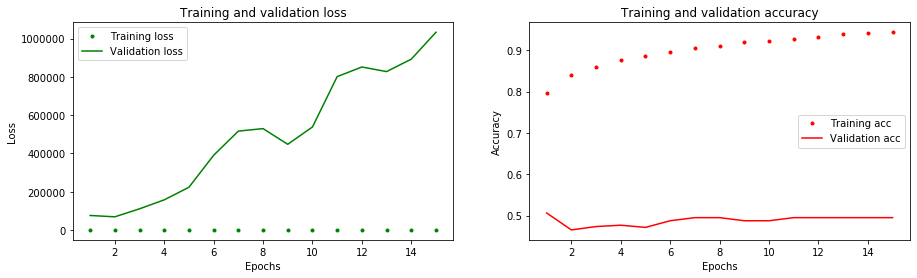

In [180]:
hist = history_1.history
loss_values = hist['loss']
val_loss_values = hist['val_loss']
acc_values = hist['acc'] 
val_acc_values = hist['val_acc']


epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g.', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc_values, 'r.', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Model 2

In [184]:
model2 = models.Sequential()

model2.add(Dense(64, activation='relu', input_dim=143))
model2.add(Dropout(0.2))

model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.2))

model2.add(Dense(1, activation='sigmoid'))

model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc', Precision(), Recall(), AUC()])

history_2 = model2.fit(X_train2_scaled,
                       y_train2,
                       epochs=15,
                       validation_data=(X_val, y_val))

# print metrics
score = model2.evaluate(X_test2_scaled, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test precision:', score[2])
print('Test recall:', score[3])
print('Test AUC:', score[4])

Epoch 1/15
601/601 [==============================] - 1s 2ms/step - loss: 0.4622 - acc: 0.7808 - precision_11: 0.7523 - recall_11: 0.8352 - auc_11: 0.8534 - val_loss: 91101.6406 - val_acc: 0.5048 - val_precision_11: 0.5048 - val_recall_11: 1.0000 - val_auc_11: 0.5000
Epoch 2/15
601/601 [==============================] - 1s 1ms/step - loss: 0.4008 - acc: 0.8166 - precision_11: 0.7805 - recall_11: 0.8792 - auc_11: 0.8869 - val_loss: 61577.9219 - val_acc: 0.5258 - val_precision_11: 0.5159 - val_recall_11: 0.9814 - val_auc_11: 0.5213
Epoch 3/15
601/601 [==============================] - 1s 1ms/step - loss: 0.3729 - acc: 0.8315 - precision_11: 0.7890 - recall_11: 0.9035 - auc_11: 0.8988 - val_loss: 42470.1602 - val_acc: 0.5223 - val_precision_11: 0.5190 - val_recall_11: 0.7344 - val_auc_11: 0.5203
Epoch 4/15
601/601 [==============================] - 1s 1ms/step - loss: 0.3516 - acc: 0.8443 - precision_11: 0.7973 - recall_11: 0.9221 - auc_11: 0.9081 - val_loss: 49892.8516 - val_acc: 0.5172 

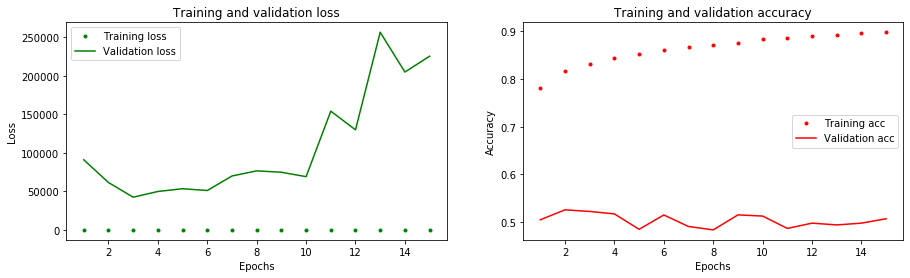

In [185]:
hist2 = history_2.history
loss_values = hist2['loss']
val_loss_values = hist2['val_loss']
acc_values = hist2['acc'] 
val_acc_values = hist2['val_acc']


epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g.', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc_values, 'r.', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Model 3

In [208]:
model3 = models.Sequential()

model3.add(Dense(64, activation='relu', input_dim=143))
model3.add(Dropout(0.4))

model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.4))

model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.4))

model3.add(Dense(32, activation='relu'))
model3.add(Dropout(0.4))

model3.add(Dense(1, activation='sigmoid'))

model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc', Precision(), Recall(), AUC()])

history_3 = model3.fit(X_train2_scaled,
                       y_train2,
                       epochs=15,
                       batch_size = 128,
                       validation_data=(X_val, y_val))

# print metrics
score = model3.evaluate(X_test2_scaled, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test precision:', score[2])
print('Test recall:', score[3])
print('Test AUC:', score[4])

Epoch 1/15
151/151 [==============================] - 1s 4ms/step - loss: 0.5915 - acc: 0.6809 - precision_31: 0.6746 - recall_31: 0.6949 - auc_31: 0.7450 - val_loss: 77009.0391 - val_acc: 0.5165 - val_precision_31: 0.5108 - val_recall_31: 1.0000 - val_auc_31: 0.5118
Epoch 2/15
151/151 [==============================] - 0s 2ms/step - loss: 0.4785 - acc: 0.7777 - precision_31: 0.7397 - recall_31: 0.8549 - auc_31: 0.8447 - val_loss: 84074.9766 - val_acc: 0.5165 - val_precision_31: 0.5108 - val_recall_31: 1.0000 - val_auc_31: 0.5118
Epoch 3/15
151/151 [==============================] - 0s 2ms/step - loss: 0.4535 - acc: 0.7909 - precision_31: 0.7463 - recall_31: 0.8794 - auc_31: 0.8574 - val_loss: 63703.4922 - val_acc: 0.5165 - val_precision_31: 0.5108 - val_recall_31: 1.0000 - val_auc_31: 0.5118
Epoch 4/15
151/151 [==============================] - 0s 2ms/step - loss: 0.4347 - acc: 0.7998 - precision_31: 0.7530 - recall_31: 0.8904 - auc_31: 0.8682 - val_loss: 65150.3555 - val_acc: 0.5206 

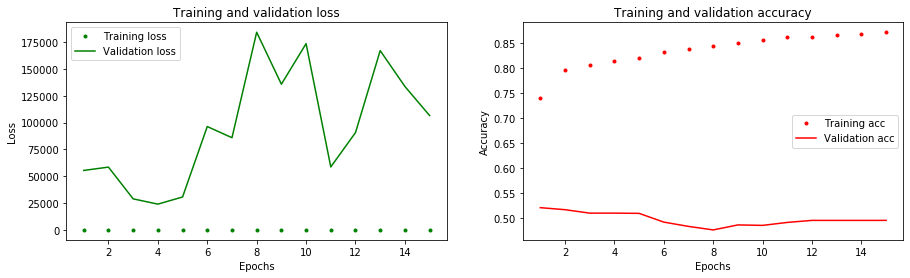

In [206]:
hist3 = history_3.history
loss_values = hist3['loss']
val_loss_values = hist3['val_loss']
acc_values = hist3['acc'] 
val_acc_values = hist3['val_acc']


epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g.', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc_values, 'r.', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()